In [7]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import random

In [8]:
# Load the dataset
initial_df = pd.read_csv("data/Derivation_dataset.csv")  # <- update path if needed
target_col = 'Outcome_Occlusion_MI'  # This column is ignored

# Drop rows with any NaN values
initial_df = initial_df.dropna()

# Ensure column names do not have leading/trailing spaces
initial_df.columns = initial_df.columns.str.strip()

selected_columns = [
    "st80_aVF", "st80_aVL", "tamp_III", "tamp_aVF", "st80_V6",
    "st80_III", "st80_V2", "tamp_aVL", "st80_V1", "tamp_V2",
    "st80_I", "tamp_I", "TpTe", "st80_V3", "tamp_V6", "fpTinfl1Axis",
    "QRSd", "tamp_V5", "fpTinfl1Mag", "HR", "pcaTamp", "mfpQRSaxis",
    "Tamp", "TrelAmp", "QRSTangle"
]

df = initial_df[selected_columns].copy()



# Drop the target and impute missing values
X_raw = df
columns = X_raw.columns
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)
n, d = X.shape

In [9]:
# === Helper Functions ===

def compute_bic(dag, X, n):
    """Compute BIC score of the DAG structure assuming linear Gaussian CPDs."""
    bic_score = 0
    for i in range(d):
        parents = list(dag.predecessors(i))
        y = X[:, i]
        if parents:
            X_parents = X[:, parents]
            model = LinearRegression().fit(X_parents, y)
            residuals = y - model.predict(X_parents)
            rss = np.sum(residuals ** 2)
            sigma2 = rss / n
        else:
            sigma2 = np.var(y)
        log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
        k = len(parents) + 1
        bic_score += log_likelihood - 0.5 * k * np.log(n)
    return bic_score

def get_random_neighbors(dag, d, sample_size=200):
    """Generate a random sample of neighboring DAGs by modifying a single edge."""
    neighbors = []
    for i in range(d):
        for j in range(d):
            if i == j:
                continue
            if dag.has_edge(i, j):
                # Try removing
                temp = dag.copy()
                temp.remove_edge(i, j)
                if nx.is_directed_acyclic_graph(temp):
                    neighbors.append(temp)
                # Try reversing
                temp = dag.copy()
                temp.remove_edge(i, j)
                temp.add_edge(j, i)
                if nx.is_directed_acyclic_graph(temp):
                    neighbors.append(temp)
            else:
                # Try adding
                temp = dag.copy()
                temp.add_edge(i, j)
                if nx.is_directed_acyclic_graph(temp):
                    neighbors.append(temp)
    return random.sample(neighbors, min(sample_size, len(neighbors)))


In [10]:
# === Greedy Search ===

# Start from empty DAG
dag = nx.DiGraph()
dag.add_nodes_from(range(d))

best_score = compute_bic(dag, X, n)
iteration = 0
improved = True

print("Starting Greedy Search...")

while improved and iteration < 100:
    iteration += 1
    improved = False
    neighbors = get_random_neighbors(dag, d, sample_size=150)
    scores = [(compute_bic(neigh, X, n), neigh) for neigh in neighbors]
    scores.sort(reverse=True, key=lambda x: x[0])
    if scores and scores[0][0] > best_score + 1e-3:
        best_score, dag = scores[0]
        improved = True
        print(f"Iteration {iteration}: BIC = {best_score:.2f}, Edges = {len(dag.edges())}")
    else:
        print(f"Iteration {iteration}: No improvement.")

Starting Greedy Search...
Iteration 1: BIC = -495747.92, Edges = 1
Iteration 2: BIC = -493563.93, Edges = 2
Iteration 3: BIC = -490495.77, Edges = 3
Iteration 4: BIC = -488217.39, Edges = 4
Iteration 5: BIC = -486273.47, Edges = 5
Iteration 6: BIC = -484598.55, Edges = 6
Iteration 7: BIC = -483300.64, Edges = 7
Iteration 8: BIC = -481909.27, Edges = 8
Iteration 9: BIC = -479954.09, Edges = 9
Iteration 10: BIC = -478734.54, Edges = 10
Iteration 11: BIC = -477484.80, Edges = 11
Iteration 12: BIC = -476429.30, Edges = 12
Iteration 13: BIC = -475303.94, Edges = 13
Iteration 14: BIC = -473824.83, Edges = 14
Iteration 15: BIC = -472588.59, Edges = 15
Iteration 16: BIC = -471691.95, Edges = 16
Iteration 17: BIC = -470795.86, Edges = 17
Iteration 18: BIC = -470029.75, Edges = 18
Iteration 19: BIC = -468915.24, Edges = 19
Iteration 20: BIC = -467883.22, Edges = 20
Iteration 21: BIC = -467090.97, Edges = 21
Iteration 22: BIC = -466325.91, Edges = 22
Iteration 23: BIC = -465574.78, Edges = 23
Ite

In [11]:
# Final learned structure
learned_edges = [(columns[i], columns[j]) for i, j in dag.edges()]
print("\nTop 100 edges in the learned DAG:")
print(learned_edges[:100])


Top 100 edges in the learned DAG:
[('st80_aVF', 'st80_III'), ('st80_aVF', 'st80_V6'), ('st80_aVF', 'st80_I'), ('st80_aVF', 'st80_V3'), ('st80_aVF', 'pcaTamp'), ('st80_aVF', 'fpTinfl1Mag'), ('st80_aVF', 'fpTinfl1Axis'), ('st80_aVL', 'st80_III'), ('st80_aVL', 'st80_I'), ('st80_aVL', 'st80_aVF'), ('st80_aVL', 'st80_V6'), ('tamp_III', 'tamp_aVF'), ('tamp_III', 'tamp_aVL'), ('tamp_III', 'tamp_I'), ('tamp_III', 'fpTinfl1Axis'), ('tamp_III', 'st80_III'), ('tamp_III', 'st80_aVL'), ('tamp_aVF', 'st80_aVF'), ('tamp_aVF', 'Tamp'), ('tamp_aVF', 'tamp_aVL'), ('tamp_aVF', 'tamp_I'), ('tamp_aVF', 'st80_V6'), ('tamp_aVF', 'fpTinfl1Axis'), ('tamp_aVF', 'st80_III'), ('tamp_aVF', 'mfpQRSaxis'), ('st80_V6', 'TrelAmp'), ('st80_V6', 'st80_V1'), ('st80_III', 'st80_V1'), ('st80_III', 'mfpQRSaxis'), ('st80_V2', 'st80_V1'), ('st80_V2', 'st80_V3'), ('st80_V2', 'tamp_V6'), ('st80_V2', 'st80_aVL'), ('st80_V2', 'pcaTamp'), ('st80_V2', 'tamp_aVL'), ('st80_V2', 'tamp_V5'), ('tamp_aVL', 'tamp_I'), ('tamp_aVL', 'st80_

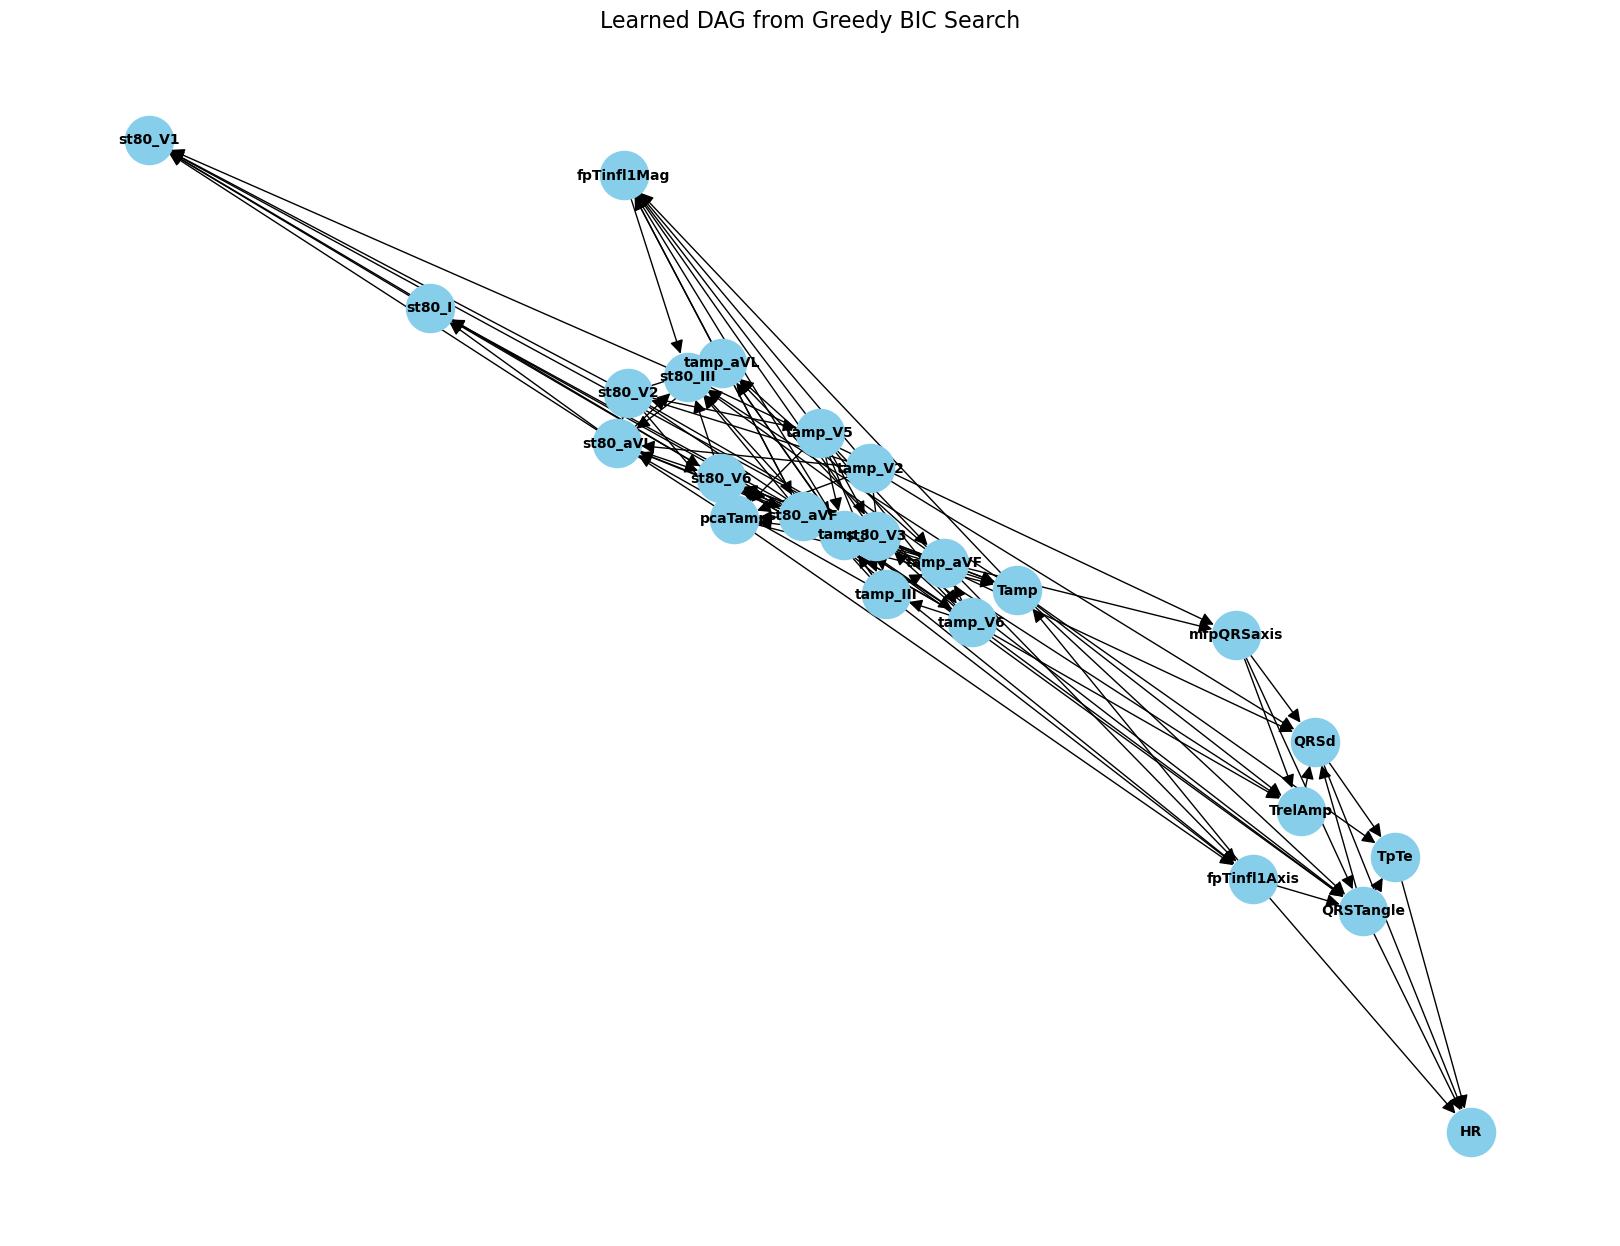

In [13]:
import matplotlib.pyplot as plt

# Plotting the learned DAG
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(dag, seed=42)
nx.draw(
    dag, pos, with_labels=True,
    labels={i: col for i, col in enumerate(columns)},
    node_size=1200, node_color='skyblue',
    font_size=10, font_weight='bold', arrowsize=20
)
plt.title("Learned DAG from Greedy BIC Search", fontsize=16)
plt.show()
